In [1]:
from ising_model import OlfactionIsingModel
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, value_and_grad, jit, vmap, lax, jit, tree_util, nn
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.ndimage import maximum_filter
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.cm as cm


# Model QC: Synthetic data 
one way to QC this is to write synthetic data and check if we can match it. Do this in a regime where h, J are close to 0 but vary enough that there's an easy signal to follow. 

In [2]:
DATA_PATH = '../vcf/Matrix2.csv'

In [3]:
def write_synthetic_data(key, oim, N, h, J): 
    data = oim.generate_independent_samples(key, h, J, samples=10000)
    pd.DataFrame((data + 1) // 2).to_csv('synthetic_data.csv') 
    return data


# N = 2

In [4]:
key = jax.random.PRNGKey(1)
N = 2
p = 1.0
h = jax.random.normal(key, shape=(N, ))
h =  (.1 * jax.random.normal(key, shape=(N, )) - .5) # make h really small to make the means small. This makes the product of means term small and hopefully make the J signal better. But then you can't get a high covariance no matter what you do. 
J = 3 * jax.random.normal(key, shape=(N, N))
mask = jax.random.bernoulli(key, p=p, shape=(N, N))
J = J * mask 
J = 1/2 * (J + J.T) * (1 - jnp.eye(N))
# J = jnp.zeros((N, N))
key = jax.random.PRNGKey(5)
writing_oim = OlfactionIsingModel(DATA_PATH, key, fraction=1)
writing_oim.burnin = 2000
writing_oim.tau = 200
d = write_synthetic_data(key, writing_oim, 10, h, J) 

# N = 10

If you draw sparse J randomly, and h is gamma distributed (so mostly low), it's unlikely that your high Js will co-occur with your high hs, and you will see no empirical covariances in your data. So you need to force J to be non-zero for the high hs. 

In [195]:
def create_J(key, h, J_scale): 
    J = jnp.zeros((len(h), len(h)))
    values, indices = jax.lax.top_k(h, len(h) // 3)
    mask = jnp.ix_(indices, indices) 
    gamma_Js = J_scale * jax.random.gamma(key, 1, (len(values), len(values)))
    return J.at[mask].set(gamma_Js) * (1 - jnp.eye(len(J)))

In [196]:
key = jax.random.PRNGKey(1) 
N = 10
p = 1.0
h = (jax.random.gamma(key, 1, shape=(N, )) - 2) / 0.5
J = create_J(key, h, 1) 
# J = 0 * (jax.random.gamma(key, a=1, shape=(N, N))) * 1 / N
# mask = jax.random.bernoulli(key, p=p, shape=(N, N))
# J = J * mask 
# J = 1/2 * (J + J.T) * (1 - jnp.eye(N))


In [197]:
key = jax.random.PRNGKey(5)
writing_oim = OlfactionIsingModel(DATA_PATH, key, fraction=0.1)
writing_oim.burnin = 2000
writing_oim.tau = 200
d = write_synthetic_data(key, writing_oim, N, h, J) 

In [198]:
d.shape

(10, 10000)

In [200]:
h

Array([-0.98478293,  0.12459707, -1.262876  , -3.5459285 , -1.0736575 ,
       -3.9022772 , -1.9648423 , -2.2311583 , -0.5030179 , -3.8905222 ],      dtype=float32)

In [201]:
jnp.mean(d == 1, axis=1) 

Array([1.16799995e-01, 3.54099989e-01, 7.14000016e-02, 7.99999980e-04,
       9.56999958e-02, 8.99999985e-04, 1.81999989e-02, 1.04000000e-02,
       3.16499978e-01, 1.99999995e-04], dtype=float32)

In [202]:
covs = jnp.cov((d + 1) // 2) * (1 - jnp.eye(len(d)))

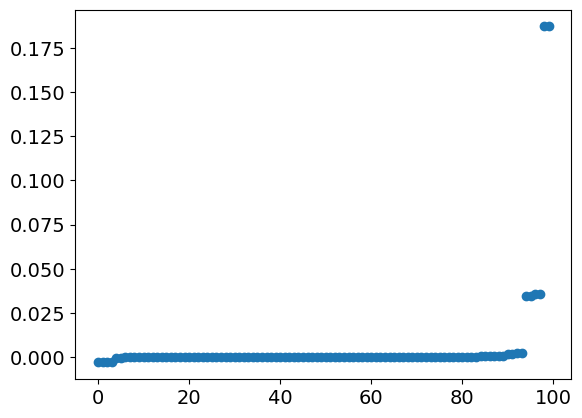

In [203]:
plt.scatter(range(len(covs.flatten())), jnp.sort(covs.flatten()))

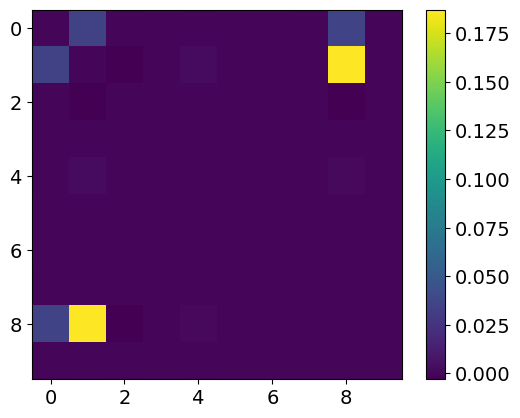

In [204]:
plt.imshow(jnp.cov((d + 1) // 2) * (1 - jnp.eye(len(d)))) 
plt.colorbar()

Remember: $ \langle (\sigma_i - \langle \sigma_i \rangle) (\sigma_j - \langle \sigma_j \rangle ) \rangle  = \langle \sigma_i \sigma_j \rangle - \langle \sigma_i \rangle \langle \sigma_j \rangle$

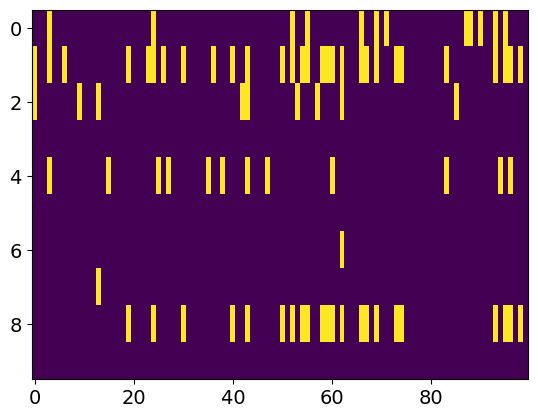

In [205]:
fig, ax = plt.subplots()
ax.imshow(d[:, :100], aspect='auto')

Now train an ising model to match this 

In [206]:
key = jax.random.PRNGKey(0)
synthetic_data = 'synthetic_data.csv'
oim = OlfactionIsingModel(synthetic_data, key)
N = oim.data.shape[0]
oim.burnin = 2000
oim.tau = 200 

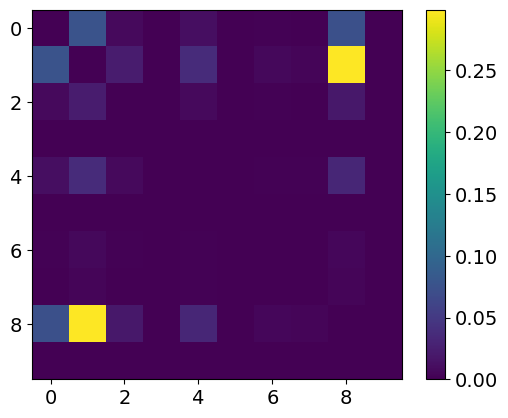

In [207]:
plt.imshow(oim.empirical_cov * (1 - jnp.eye(len(oim.empirical_cov)))) 
plt.colorbar()

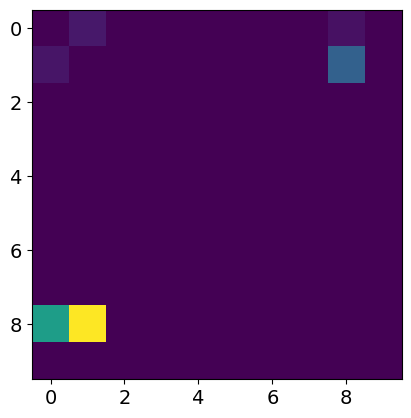

In [208]:
plt.imshow(J) 

In [209]:
def mask_and_symmetrize(array): 
    return (array + array.T) / 2 * (1 - jnp.eye(len(array)))

In [210]:
h_init = oim.fit_h_to_empirical_means() 
# J_init = J + .1 * mask_and_symmetrize(jax.random.normal(key, J.shape)) 
J_init = jnp.zeros(J.shape) 

# Fitting and plotting parameter trajectories 

In [221]:
stages, iterations = 2, 10
new_h, new_J, h_traj, J_traj = oim.optimize_ising_model(key, h, J_init, eta=1, h_eta=0, J_eta=1, k=100, stages=stages, iterations=iterations) 

In [222]:
def plot_h_trajectory(h_traj, true_h, number_trajectories=None): 
    flat_h = jnp.reshape(h_traj, (h_traj.shape[0] * h_traj.shape[1], h_traj.shape[2])) 
    if number_trajectories is None: 
        number_trajectories = len(true_h) 
    label = ''    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(number_trajectories):
        axs[0].plot(range(len(flat_h)), jnp.abs(flat_h[:, i] - true_h[i]), label=label)
        axs[1].plot(range(len(flat_h)), flat_h[:, i], label=label) 
        axs[1].hlines(true_h[1], xmin=0, xmax=len(flat_h) - 1, color='tab:orange', ls='--', label='true h')
        # ax.set_yscale('log') 

def plot_J_trajectory(J_traj, true_J, number_trajectories=None):
    flat_J = jnp.reshape(J_traj, (J_traj.shape[0] * J_traj.shape[1], J_traj.shape[2] * J_traj.shape[3])) 
    flat_true_J = J.flatten()
    if number_trajectories is None: 
        number_trajectories =  len(flat_true_J) 

    label = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(number_trajectories):
        axs[0].plot(range(len(flat_J)), jnp.abs(flat_J[:, i] - flat_true_J[i]), label=label)
        l = axs[1].plot(range(len(flat_J)), flat_J[:, i], label=label)[0]
        axs[1].hlines(flat_true_J[i], xmin=0, xmax=len(flat_J) - 1, color=l.get_color(), ls='--', label='true h')
        # ax.set_yscale('log') 
    

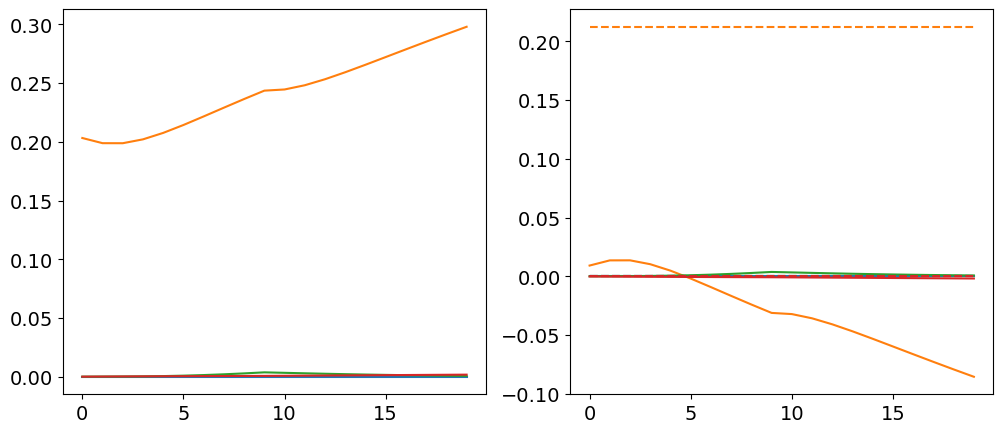

In [223]:
plot_J_trajectory(J_traj, J, number_trajectories=4) 

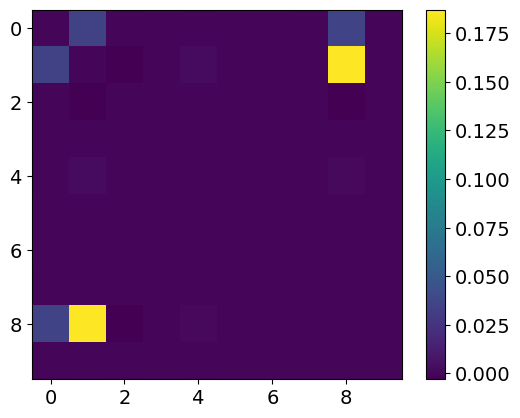

In [220]:
# plt.imshow(oim.empirical_cov * (1 - jnp.eye(len(oim.data)))) 
plt.imshow(jnp.cov(oim.data.values) * (1 - jnp.eye(len(oim.data))))
plt.colorbar()

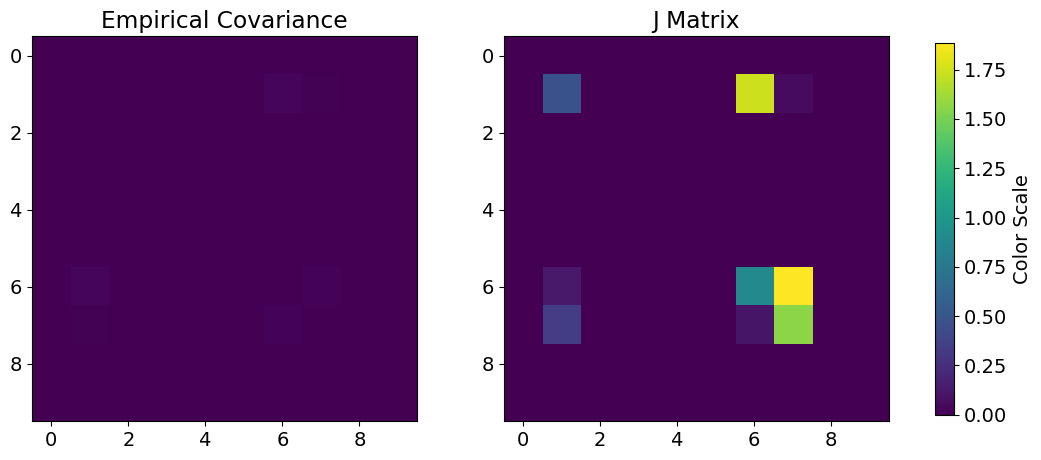

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Define shared colormap and norm based on data range
vmin = min(oim.empirical_cov.min(), J.min())
vmax = max(oim.empirical_cov.max(), J.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.viridis

# Plot first image
im1 = ax[0].imshow(oim.empirical_cov * (1 - jnp.eye(len(oim.empirical_cov))), cmap=cmap, norm=norm)
ax[0].set_title("Empirical Covariance")

# Plot second image
im2 = ax[1].imshow(J, cmap=cmap, norm=norm)
ax[1].set_title("J Matrix")

# Add a single colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', fraction=0.02, pad=0.05)
cbar.set_label("Color Scale")

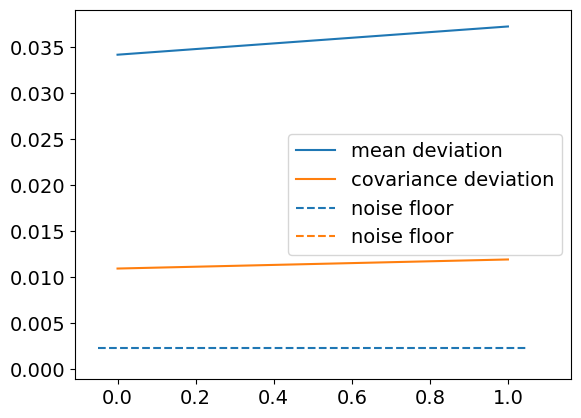

In [118]:
fig, ax, m, c = oim.plot_deviation_timecourse(key, h_traj, J_traj, subsample=1)
ax.legend()

In [12]:
oim.empirical_cov

Array([[0.18690643, 0.15961349],
       [0.15961349, 0.20071928]], dtype=float32)

In [14]:
flat_h = jnp.reshape(h_traj, (stages * iterations, N))
flat_h = jnp.concat([h_init.reshape(1, N), flat_h])
flat_J = jnp.reshape(J_traj, (stages * iterations, N*N))
flat_J = jnp.concat([jnp.reshape(J_init, (1, N*N)), flat_J])
flat_true_J = J.flatten()

In [13]:
mfloor, cfloor = oim.compute_background_average_deviations(key)

In [14]:
mfloor, cfloor

(Array(0.0041231, dtype=float32), Array(0.00183634, dtype=float32))

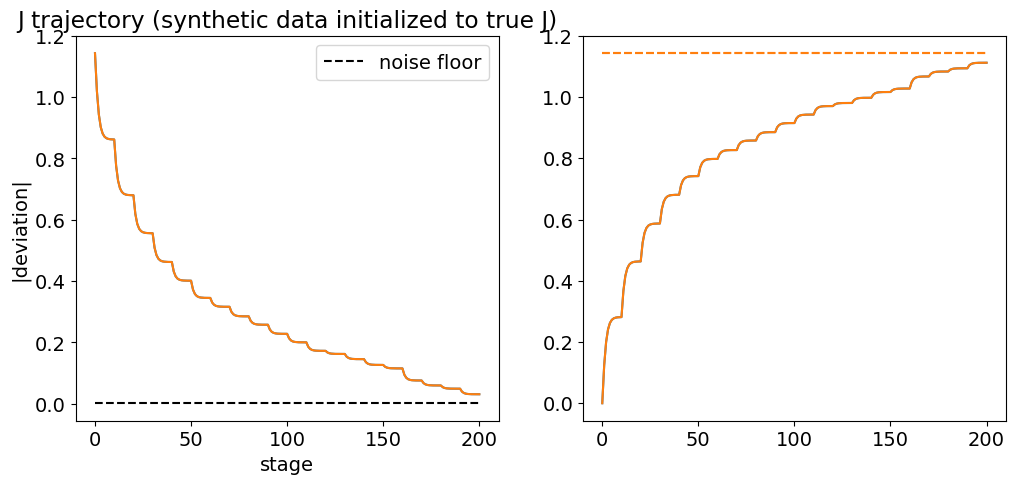

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
for i in range(1, len(flat_true_J) // 1 -1):
    label = f'{flat_true_J[i]}'
    label = None
    ax.plot(range(len(flat_J)), jnp.abs(flat_J[:, i] - flat_true_J[i]), label=label)
    axs[1].plot(range(len(flat_J)), flat_J[:, i], label=label) 
    axs[1].hlines(flat_true_J[1], xmin=0, xmax=len(flat_J) - 1, color='tab:orange', ls='--', label='true J')
    # ax.set_yscale('log') 

ax.hlines(cfloor, 0, len(flat_J) - 1, ls='--', color='black', label='noise floor')
ax.set_xlabel('stage')
ax.set_ylabel('|deviation|')
ax.legend()
ax.set_title('J trajectory (synthetic data initialized to true J)') 
fig.savefig('tmp.png', bbox_inches='tight')

In [81]:
d = oim.generate_independent_samples(key, h, J_traj[140, 0], samples=10000, burnin=300, tau=30) / 2 + 1/2 

In [84]:
J_traj[140, 0]

Array([[0.      , 1.224491],
       [1.224491, 0.      ]], dtype=float32)

In [85]:
h

Array([-0.51161706, -0.27874935], dtype=float32)

In [82]:
oim.compute_averages(d, centered=False) 

(Array([0.1838, 0.2004], dtype=float32),
 Array([[0.1838128 , 0.15990597],
        [0.15990597, 0.20041929]], dtype=float32))

In [83]:
oim.set_empirical_means()

(Array([0.18689999, 0.2007    ], dtype=float32),
 Array([[0.18690643, 0.15961349],
        [0.15961349, 0.20071928]], dtype=float32))

In [54]:
J_traj[-1, 0]

Array([[0.       , 1.2052909],
       [1.2052909, 0.       ]], dtype=float32)

In [95]:
J

Array([[ 0.      ,  1.143194],
       [ 1.143194, -0.      ]], dtype=float32)

In [106]:
d_i = oim.generate_independent_samples(key, h, J, samples=10000) / 2 + 1/2

In [107]:
oim.compute_averages(d_i)

(Array([0.1915, 0.2051], dtype=float32),
 Array([[0.15483457, 0.12175073],
        [0.12175073, 0.16305591]], dtype=float32))

In [108]:
oim.empirical_mean

Array([0.2007    , 0.18689999], dtype=float32)

In [104]:
oim.compute_averages(d)

(Array([0.163, 0.17 ], dtype=float32),
 Array([[0.13656625, 0.11940936],
        [0.11940936, 0.14124171]], dtype=float32))

In [109]:
oim.empirical_cov

Array([[0.20071928, 0.15961349],
       [0.15961349, 0.18690643]], dtype=float32)

In [56]:
jnp.cov((d + 1) // 2) + jnp.mean((d+1)//2, axis=1)[0] * jnp.mean((d+1)//2, axis=1)[1]

Array([[0.18608417, 0.16411065],
       [0.16411065, 0.19205272]], dtype=float32)

In [44]:
jnp.cov((d_init + 1) // 2) 

Array([[0.1503484 , 0.12837487],
       [0.12837487, 0.15631695]], dtype=float32)